<a href="https://colab.research.google.com/github/akki0894/Advanced-Data-Analytics/blob/main/Detect_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data & Description: https://www.kaggle.com/c/nlp-getting-started

In [584]:
import pandas as pd
import seaborn as sns
import numpy as np
import string
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
pd.set_option('display.max_colwidth', -1)
train_data = pd.read_csv('train.csv')
train_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [585]:
test_data = pd.read_csv('test.csv')
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [586]:
test_data.shape

(3263, 4)

In [587]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [588]:
test_id = test_data['id']

#Removing Dupicates

In [589]:
duplicates_record = train_data[train_data.duplicated(['text'], keep=False)]
duplicates_record

,id,keyword,location,text,target
40,59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw,0
48,68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw,0
106,156,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vAM5POdGyw | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/zEVakJaPcz,0
115,165,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vAM5POdGyw | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/zEVakJaPcz,0
118,171,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/THyzOMVWU0 | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/83jOO0xk29,0
...,...,...,...,...,...
7600,10855,NaN,NaN,Evacuation order lifted for town of Roosevelt: http://t.co/EDyfo6E2PU http://t.co/M5KxLPKFA1,1
7607,10867,NaN,NaN,#stormchase Violent Record Breaking EF-5 El Reno Oklahoma Tornado Nearly Runs Over ... - http://t.co/3SICroAaNz http://t.co/I27Oa0HISp,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1


In [590]:
duplicates_record.shape

(179, 5)

In [591]:
train_data.drop_duplicates(subset = ['text','target'], keep = 'first', inplace = True, ignore_index = True)

In [592]:
duplicates_record = train_data[train_data.duplicated(['text'], keep=False)]
duplicates_record.head(6)

,id,keyword,location,text,target
606,881,bioterrorism,NaN,To fight bioterrorism sir.,1
620,898,bioterrorism,NaN,To fight bioterrorism sir.,0
1190,1723,buildings%20burning,"Mackay, QLD, Australia",Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...,1
1207,1752,buildings%20burning,"Epic City, BB.",I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????,0
1214,1760,buildings%20burning,dallas,like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit,1
1323,1922,burning%20buildings,"Mackay, QLD, Australia",Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...,0


In [593]:
train_data.drop_duplicates(subset = ['text'], keep = False, inplace = True, ignore_index = True)


#Checking for missing values

In [594]:
train_data.isna().sum()

id          0   
keyword     56  
location    2472
text        0   
target      0   
dtype: int64

In [595]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [596]:
train_data[~train_data['location'].isna()]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N,0
...,...,...,...,...,...
7452,10826,wrecked,TN,On the bright side I wrecked http://t.co/uEa0txRHYs,0
7454,10829,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thought the wife who wrecked her cake was a goner mind lol #whoops,0
7456,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty much all been wrecked hahaha shoutout to my family for that one,0
7457,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words that wrecked Disney's stock http://t.co/7enNulLKzM,0


In [597]:
train_data['target'].value_counts()

0    4297
1    3188
Name: target, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


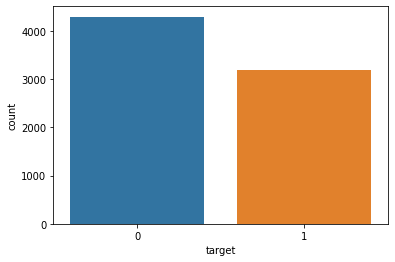

In [598]:
sns.countplot(train_data['target'])

In [599]:
Y = train_data['target']
train_data.drop('target', axis = 1, inplace = True)

In [600]:
train_data.shape

(7485, 4)

In [601]:
test_data.shape

(3263, 4)

In [602]:
train_data.head()

,id,keyword,location,text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California"
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school


Here, i am combining the train and test dataset, before converting word to vectors. The reason is if we do it separately then there is a good chance that the vector we will get in train set and test set will not be same and while predicting the test tweet the train and test features should be same.

In [603]:
train_data = pd.concat([train_data,test_data], axis = 0)

In [604]:
train_data.shape

(10748, 4)

# Data Cleaning

In [605]:
alpha = [' ','a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

Here is the 2 method (Stemmer and Lemmatizer) to bring the word to its root word.

In [606]:
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()

In [607]:
train_data['keyword'].nunique()

221

Lets not remove missing value present in Keyword, instead we can replace the NaN with Text 'missing'. in order to avoid data loss.

In [608]:
train_data['keyword'] = np.where(train_data['keyword'].isna(),'missing', train_data['keyword'])

In [609]:
train_data['keyword'].unique()

array(['missing', 'ablaze', 'accident', 'aftershock',
       'airplane%20accident', 'ambulance', 'annihilated', 'annihilation',
       'apocalypse', 'armageddon', 'army', 'arson', 'arsonist', 'attack',
       'attacked', 'avalanche', 'battle', 'bioterror', 'bioterrorism',
       'blaze', 'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard',
       'blood', 'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail'

Now lets clean the keyword, as we see in some of the keyword '%20' is added not sure why and how, but lets remove those.

In [610]:
def cleanKeyword(text):
    
    text = text.lower()   # to convert to all lower case text.
    text = text.replace('%20',' ')   # Remove '%20' if present.
    text = ' '.join([ps.stem(word) for word in text.split(' ')]) # To bring the word to its root word.
    
    return text

In [611]:
train_data['clean_keyword'] = train_data['keyword'].apply(cleanKeyword)

In [612]:
train_data['clean_keyword'].unique()

array(['miss', 'ablaz', 'accid', 'aftershock', 'airplan accid', 'ambul',
       'annihil', 'apocalyps', 'armageddon', 'armi', 'arson', 'arsonist',
       'attack', 'avalanch', 'battl', 'bioterror', 'blaze', 'bleed',
       'blew up', 'blight', 'blizzard', 'blood', 'bloodi', 'blown up',
       'bodi bag', 'bomb', 'bridg collaps', 'build burn', 'build on fire',
       'burn', 'burn build', 'bush fire', 'casualti', 'catastroph',
       'chemic emerg', 'cliff fall', 'collaps', 'collid', 'collis',
       'crash', 'crush', 'curfew', 'cyclon', 'damag', 'danger', 'dead',
       'death', 'debri', 'delug', 'demolish', 'demolit', 'derail',
       'desol', 'destroy', 'destruct', 'deton', 'devast', 'disast',
       'displac', 'drought', 'drown', 'dust storm', 'earthquak',
       'electrocut', 'emerg', 'emerg plan', 'emerg servic', 'engulf',
       'epicentr', 'evacu', 'explod', 'explos', 'eyewit', 'famin',
       'fatal', 'fear', 'fire', 'fire truck', 'first respond', 'flame',
       'flatten', 'fl

In [613]:
train_data['clean_keyword'].nunique()

167

Much cleaner and shorter, Earlier there were total 221 unique values and now after cleaning it reduced to 167.

# Removing StopWords

In [614]:
stopWords = stopwords.words('english')

In [615]:
punct = string.punctuation
punct

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [616]:
def cleanText(text):
    
    text = text.lower() # change to lower case
    text = ''.join([char for char in text if char in alpha]) # remove anything that is not an alphabet.
    text = ' '.join([ps.stem(word) for word in text.split(' ') if ((word not in stopWords) & (len(word)>1))])  # Bring the word to its root word.
    
    return text

In [617]:
train_data['text_clean'] = train_data['text'].apply(cleanText)

In [618]:
train_data.head()

,id,keyword,location,text,clean_keyword,text_clean
0,1,missing,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,miss,deed reason earthquak may allah forgiv us
1,4,missing,NaN,Forest fire near La Ronge Sask. Canada,miss,forest fire near la rong sask canada
2,5,missing,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,miss,resid ask shelter place notifi offic evacu shelter place order expect
3,6,missing,NaN,"13,000 people receive #wildfires evacuation orders in California",miss,peopl receiv wildfir evacu order california
4,7,missing,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,miss,got sent photo rubi alaska smoke wildfir pour school


In [619]:
train_data['clean_tweet'] = train_data['text_clean'] + ' ' + train_data['clean_keyword']

# Data Pre-Processing and fitting it into SGD

In [620]:
vector = TfidfVectorizer(sublinear_tf=True, max_features=2700)
X = vector.fit_transform(train_data['clean_tweet'].values)

Here, for max_features i am taking value as 2700, As i tried with several values from 500 to 3000, and 2700 was giving best accuracy.

Also it is important to select some value for max_features as if it is not selected then the method (TfidfVectorizer) will create feature for each word and you will end up in getting very very very large number of features (in this case it was more tha 25000) and while creating model you may get memory error.

And by giving some values (lets say 2700) to max_features, it will select 2700 most important features.

In [621]:
X_col = vector.get_feature_names()

In [622]:
df = pd.DataFrame.sparse.from_spmatrix(X, columns = X_col)

In [623]:
df.head()

,aba,abandon,abbswinston,abc,abcnew,abl,ablaz,abomb,abort,absolut,abstorm,abus,accept,access,accid,accident,accord,account,accus,acid,acr,across,act,action,activ,actual,ad,add,address,administr,admit,adult,advanc,advic,advisori,af,affect,affili,afghan,afghanistan,...,write,writer,written,wrong,wrought,wtf,ww,wwii,wx,xbox,xd,ya,yahoo,yall,yay,yazidi,ye,yeah,year,yearold,yemen,yesterday,yet,yo,york,youd,youll,young,youngheroesid,your,youth,youtub,youv,yr,yyc,zero,zionist,zombi,zone,zouma
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [624]:
df.shape

(10748, 2700)

In [625]:
test_data = df.iloc[7485:]

In [626]:
test_data.reset_index(drop = True , inplace = True)

In [627]:
test_data.head()

,aba,abandon,abbswinston,abc,abcnew,abl,ablaz,abomb,abort,absolut,abstorm,abus,accept,access,accid,accident,accord,account,accus,acid,acr,across,act,action,activ,actual,ad,add,address,administr,admit,adult,advanc,advic,advisori,af,affect,affili,afghan,afghanistan,...,write,writer,written,wrong,wrought,wtf,ww,wwii,wx,xbox,xd,ya,yahoo,yall,yay,yazidi,ye,yeah,year,yearold,yemen,yesterday,yet,yo,york,youd,youll,young,youngheroesid,your,youth,youtub,youv,yr,yyc,zero,zionist,zombi,zone,zouma
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.363786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [628]:
train_df = df.iloc[:7485]

In [629]:
test_data.shape

(3263, 2700)

In [630]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# create model
model = SGDClassifier()
# evaluate model
scores = cross_val_score(model,train_df, Y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: ',((scores).mean()))

Accuracy:  0.7999957162134184


In [631]:
model.fit(train_df, Y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [632]:
count_vector = CountVectorizer(encoding='utf-8', max_features=2500)
X_count = count_vector.fit_transform(train_data['clean_tweet'].values)

In [633]:
X_count_col = count_vector.get_feature_names()

In [634]:
train_mat = pd.DataFrame.sparse.from_spmatrix(X_count, columns = X_count_col)

In [635]:
train_mat.head()

,aba,abandon,abc,abcnew,abl,ablaz,abomb,absolut,abstorm,abus,accept,access,accid,accident,accord,account,accus,acid,acr,across,act,action,activ,actual,ad,add,address,administr,admit,adult,advanc,advisori,af,affect,affili,afghan,afghanistan,afraid,africa,aftermath,...,wreck,wreckag,write,writer,wrong,wrought,wtf,ww,wwii,wx,xbox,xd,ya,yall,yay,yazidi,ye,yeah,year,yearold,yemen,yesterday,yet,yo,york,youd,youll,young,youngheroesid,your,youth,youtub,youv,yr,yyc,zero,zionist,zombi,zone,zouma
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [636]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# create model
model = SGDClassifier()
# evaluate model
scores = cross_val_score(model,train_df, Y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: ',((scores).mean()))

Accuracy:  0.8005313680272449


In [637]:
model.fit(train_df, Y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [638]:
y_pred = model.predict(test_data)

In [639]:
len(y_pred)

3263

In [640]:
submit=pd.DataFrame()
submit['id'] = test_id
submit['target'] = y_pred # our model predictions on the test dataset

submit.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
